Compare no power control with UD-DPC in the noise-limited and interferencelimited scenarios. Set $P_{max}$ = 30 dBm, $P_{min}$ = 0 dBm and the discrete power control
update step as $\mu$ = 1 dBm. As for the target SINR required in UD-DPC, let us assume
the value corresponding to the QoS target of 100 Mbps at cell border under 100 MHz
which equates to 
$\gamma_t$ = 1. All other simulation parameters are kept in the same values
used in previous exercises. What are your observations? Did fixed-target SINR-based
power control (UD-DPC) help in any of the scenarios?


In [341]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(12)

In [342]:
# Função que transforma Linear para dB
def lin2db(x):
    return 10 * np.log10(x)

# Função que transforma dB para Linear
def db2lin(x):
    return 10 ** (x / 10)

# Função que transforma Linear para dBm (watt)
def lin2dbm(x):
    return 10 * np.log10(x * 1000)

# Função que transforma dBm para Linear (watt)
def dbm2lin(x):
    return 10**(x / 10) / 1000

In [343]:
# Função que define os eixos x e y da CDF
def cdf(dados):
    '''Função que calcula a Cumulative Distribution Function (CDF) de um conjunto de dados.
    Parâmetros:
    dados: array. Conjunto de dados.
    Retorno:
    x: array. Dados ordenados.
    y: array. Probabilidade acumulada de cada dado.'''

    x = np.sort(dados)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

In [344]:
# Função que gera as coordenadas dos APs
def distribuir_APs(num_aps, area):
    '''Distributes Access Points (APs) evenly within a square area.
    
    Parameters:
    num_aps (int): The number of APs to distribute. Must be a perfect square.
    area (int): The length of the side of the square area in which to distribute the APs.
    
    Returns:
    np.array: An array of coordinates for the APs, or None if num_aps is not a perfect square.'''
    
    if num_aps not in [1, 4, 9, 16, 25, 36, 49, 64, 100]:
        return None

    tamanho_quadrado = area
    lado_quadrado = int(np.sqrt(num_aps))

    tamanho_celula = tamanho_quadrado // lado_quadrado

    # Criar coordenadas usando meshgrid
    x, y = np.meshgrid(np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula),
                      np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula))

    coordenadas_APs = np.column_stack((x.ravel(), y.ravel()))

    return coordenadas_APs

In [345]:
# Função que gera a distância entre a UE e a AP
def dAPUE(x_coord, y_coord, ap_coord, d_reference=1):
  '''Calculate the Euclidean distance between a user equipment (UE) and an access point (AP).
    
    Parameters:
    ue_coords (tuple): A tuple (x_coord, y_coord) representing the coordinates of the UE.
    ap_coords (np.array): An array containing the coordinates of the APs.
    
    Returns:
    float: The Euclidean distance between the UE and the AP. If the euclidean distance is less than 1, return 1.
  '''
  dAPUE = np.linalg.norm(np.array([x_coord, y_coord]) - ap_coord)
  if dAPUE < d_reference:
    return d_reference
  else:
    return dAPUE

In [346]:
#Função que define o shadowing para cada usuário
def find_shadowing(standard_shadow, ues, aps):
    '''Generate a shadowing value for a user.

    Parameters:
    standard_shadow (float): The standard deviation of the shadowing values.
    ues (int): The number of user equipment (UE) in the simulation.
    aps (int): The number of access points (APs) in the

    Returns:
    np.array: A 2D array of shadowing values for each UE and AP.
    '''

    shadowing = np.random.lognormal(0, standard_shadow, (ues, aps))

    return shadowing 

In [347]:
def find_fastfading(standard_fading, ues, aps, channels):
    '''Função que calcula o fast fading para um dado usuário.
    
    Parâmetros:
    standard_fading (float): O desvio padrão da distribuição normal.
    ues (int): O número de usuários.
    aps (int): O número de pontos de acesso.
    channels (int): O número de canais.
    
    Retorna:
    np.array: Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    '''

    fast_fading = np.sqrt( (standard_fading * np.random.randn(channels, ues, aps))**2 + (standard_fading * np.random.randn(channels, ues, aps))**2 )

    return fast_fading

In [348]:
# Função que calcula o path gain com a distância, shadowing e fast fading
def find_pathgain(dist, shadowing, fastfading):
    ambiente_const = 1e-4
    pathloss_const = 4


    path_gain_result = (shadowing * (ambiente_const / (dist ** pathloss_const))) * fastfading **2

    
    return path_gain_result

In [349]:
def calculate_sinr(banda, K_0, aps, ues, channels, p_t, area, x_coord, y_coord):
    '''Função que calcula a SINR para múltiplos UEs e APs em diferentes canais.

    i-th AP, j-th UE, c-th channel
    
    Lembrando que [channels, ues, aps] é a dimensão de fastfading, logo as dimensões da matriz path_gain é [channels, ues, aps]. 

    Parâmetros:
    banda (float): Largura de banda total.
    K_0 (float): Constante de ruído.
    aps (int): Número de APs.
    ues (int): Número de UEs.
    channels (int): Número de canais.
    sigma_shadowing (float): Desvio padrão para o shadowing.
    sigma_fastfading (float): Desvio padrão para o fast fading.
    p_t (np.array): Potência de transmissão de cada UE.
    rrm_index (int): Índice para o tipo de algoritmo de alocação de recursos.
    area (float): Área de distribuição dos APs.
    
    Retorna:
    np.array: O valor do SINR para cada UE.
    '''
    # Inicializações
    aps_position = distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))

    # Shadowing já definido
    shadowing = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
                          [3.2318, 1.5770, 2.6449e-1, 5.6379],
                          [6.1470e-3, 1.1424, 2.6826e-1, 4.5709],
                          [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    
    # Fast fading já definido, deixando-o no formato [channels, ues, aps]
    fastfading = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                           [0.498887, 0.104890, 0.647280, 0.940906], 
                           [0.382966, 0.682700, 1.891256, 0.327100], 
                           [0.065737, 0.649500, 1.981107, 1.259538]]).reshape(channels, ues, aps)
    
    power_trans = p_t
    power_noise = np.ones(ues) * (K_0 * banda / channels)


    # Distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    path_gain = find_pathgain(dist, shadowing, fastfading)

    # Cálculo do SINR
    sinr_total = np.zeros(path_gain.shape)
    sinr_ue = np.zeros(path_gain.shape[1])

    for ue_index in range(path_gain.shape[1]):
        for channel_index in range(path_gain.shape[0]):
            for ap_index in range(path_gain.shape[2]):
                # Calculando a potência recebida no canal atual
                power_received = np.abs(path_gain[channel_index, ue_index, ap_index]) * power_trans[ue_index]
    
                # Calculando a interferência no mesmo canal
                interference_sum = 0
                for other_ue_index in range(path_gain.shape[1]):
                    interference_sum += np.abs(path_gain[channel_index, other_ue_index, ap_index]) * power_trans[other_ue_index]

                # Cálculo da SINR para o canal, UE e AP atuais
                sinr_total[channel_index, ue_index, ap_index] = power_received / ((interference_sum-power_received) + power_noise[ue_index])

    # Selecionar o maior valor de SINR para cada UE
    for ue_index in range(sinr_total.shape[1]):
        sinr_ue[ue_index] = np.max(sinr_total[:, ue_index, :])

    return sinr_ue


In [350]:
def updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading, x_coord, y_coord): 
    # Inicializa posições dos APs e distâncias
    aps_position = distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))

    # Definindo o shadowing e o fast fading como matrizes fixas
    shadowing = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
                          [3.2318, 1.5770, 2.6449e-1, 5.6379],
                          [6.1470e-3, 1.1424, 2.6826e-1, 4.5709],
                          [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    fastfading = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                           [0.498887, 0.104890, 0.647280, 0.940906], 
                           [0.382966, 0.682700, 1.891256, 0.327100], 
                           [0.065737, 0.649500, 1.981107, 1.259538]]).reshape(channels, ues, aps)

    # Calculando a distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    # Calculando o path gain
    path_gain = find_pathgain(dist, shadowing, fastfading)

    # Inicializa vetores de potência e alocação
    

    transmit_power = power_trans_max * np.ones((path_gain.shape[1], 1))
    power_sum = np.zeros(time)
    power_evolution = np.zeros((path_gain.shape[1], time))
    sinr_evolution = np.zeros((path_gain.shape[1], time))

    # Loop para cada instante de tempo
    for time_index in range(time):
        power_sum[time_index] = sum(transmit_power.flatten())

        # Salvar a evolução da potência para cada UE
        power_evolution[:, time_index] = transmit_power.flatten()

        # Calcula a SINR para cada usuário no tempo atual
        sinr_ue = calculate_sinr(banda, K_0, aps, ues, channels, dbm2lin(transmit_power), area, x_coord, y_coord)
        sinr_ue = lin2db(sinr_ue).reshape((ues, 1))

        # Salvar a evolução da SINR para cada UE
        sinr_evolution[:, time_index] = sinr_ue.flatten()

        # Atualiza a potência com base no erro entre a SINR alvo e a SINR atual
        transmit_power = transmit_power + step * np.sign(sinr_alvo - sinr_ue)

        # Aplica os limites de potência
        transmit_power = np.clip(transmit_power, power_trans_min, power_trans_max)

    return power_evolution, transmit_power, power_sum, sinr_evolution


In [351]:
def find_capacity(sinr, banda, channels):
    '''Função que calcula a capacidade de um dado canal.
    
    Parâmetros:
    sinr (array): A relação sinal ruído mais interferência.
    banda (int): A largura de banda do canal.    
    channels (int): O número de canais.
    Retorna:
    list: A capacidade do canal.'''

    capacity = banda * np.log2(1 + sinr)

    # Deixado no formato [channels, ues]
    capacity = capacity.reshape(channels, -1)

    return capacity

In [352]:
def noise_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading):
    
    x_coord = np.array([225.83, 566.79, 765.51, 265.95])
    y_coord = np.array([203.33, 321.88, 146.88, 702.39])

    # Deixando a SINR no formato [ues, time] e a capacidade no formato [ues, time]
    sinr_max_vector = np.zeros((ues, time))
    sinr_dpc_vector = np.zeros((ues, time))
    capacity_max_vector = np.zeros((ues, time))
    capacity_dpc_vector = np.zeros((ues, time))

    # Definindo os dois tipos de controle de potência a ser utilizado:
    # 1. UpDownDPC
    transmit_power_dpc = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading, x_coord, y_coord)
    # Deixando a potência no formato [ues, time]
    transmit_power_dpc = transmit_power_dpc[0].reshape(ues, time) # Esse formato foi escolhido para facilitar a visualização dos dados e achado de maneira impirica

    # 2. Power Max
    transmit_power_max = power_trans_max*np.ones((ues, time))



    for time_index in range (time):

        # Calculando a SINR para cada usuário utilizando o Power Max
        trans_power_max_lin = dbm2lin(transmit_power_max[:, time_index])

        sinr_max = calculate_sinr(banda, K_0, aps, ues, channels, trans_power_max_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o Power Max
        capacity_max = find_capacity(sinr_max, banda, channels)

        trans_power_dpc_lin = dbm2lin(transmit_power_dpc[:,time_index])

        # Calculando a SINR para cada usuário utilizando o UpDownDPC
        sinr_dpc = calculate_sinr(banda, K_0, aps, ues, channels, trans_power_dpc_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o UpDownDPC
        capacity_dpc = find_capacity(sinr_dpc, banda, channels)

        # Alocando os valores de SINR e capacidade para cada usuário para cada momento
        sinr_max_vector[:, time_index] = sinr_max
        sinr_dpc_vector[:, time_index] = sinr_dpc
        capacity_max_vector[:, time_index] = capacity_max
        capacity_dpc_vector[:, time_index] = capacity_dpc

    return sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector



        


        

In [353]:
bandwidth , transmit_power, d_min, K_0 = 100e6, 1, 1, 1e-20 # Em MHz, mW, metros, mW/Hz respectivamente
aps, ues, channels = 4, 4, 1
area_noiselimited = 1000
area_interferencelimited = 100
sigma_shadowing = 2
sigma_fastfading = 1/np.sqrt(2)


In [354]:
power_trans_max = 30 # Em dBm
power_trans_min = 0 # Em dBm
step = 1 # Em dBm

In [355]:
# Definindo o SINR alvo
sinr_alvo = 1

# Definindo o tempo de simulação
time = 100

# Fazendo a simulação
sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector = noise_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_noiselimited, sigma_shadowing, sigma_fastfading)

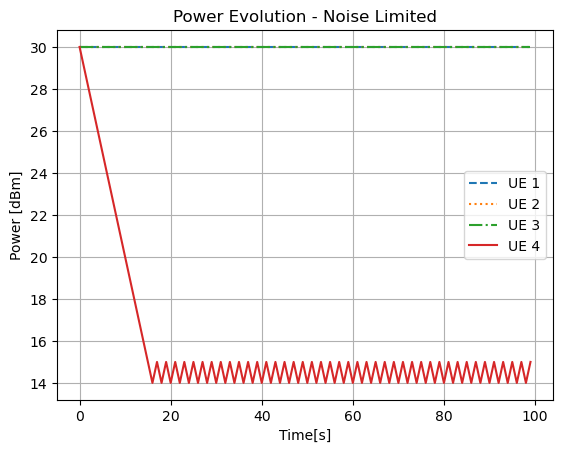

[[30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 

In [356]:
# Plotando a evolução da potência de transmissão

x_coord = [225.83, 566.79, 765.51, 265.95]
y_coord = [203.33, 321.88, 146.88, 702.39]

a = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_noiselimited, sigma_shadowing, sigma_fastfading, x_coord, y_coord)
# Descobrindo qual as dimensões de a

a = a[0]



plt.figure()
plt.plot(a[0], label='UE 1', linestyle='--')
plt.plot(a[1], label='UE 2', linestyle=':')
plt.plot(a[2], label='UE 3', linestyle='-.')
plt.plot(a[3], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - Noise Limited')
plt.show()

print(a)


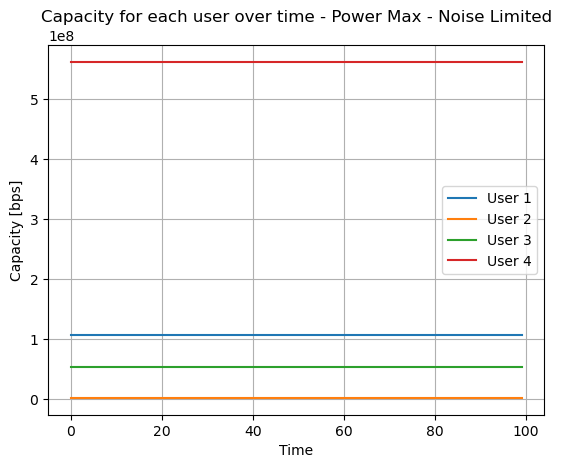

In [357]:
# Plotando a capacidade para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(capacity_max_vector[0, :], label='User 1')
plt.plot(capacity_max_vector[1, :], label='User 2')
plt.plot(capacity_max_vector[2, :], label='User 3')
plt.plot(capacity_max_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - Power Max - Noise Limited')
plt.grid()
plt.show()

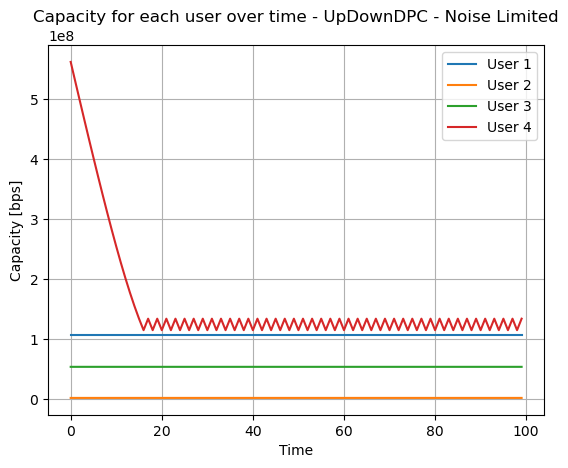

In [358]:
# Plotando a capacidade para cada usuário para cada momento utilizando o UpDownDPC

plt.figure()
plt.plot(capacity_dpc_vector[0, :], label='User 1')
plt.plot(capacity_dpc_vector[1, :], label='User 2')
plt.plot(capacity_dpc_vector[2, :], label='User 3')
plt.plot(capacity_dpc_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - UpDownDPC - Noise Limited')
plt.grid()
plt.show()


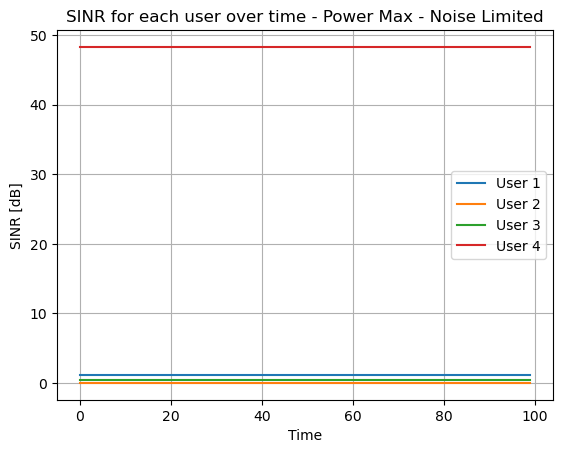

In [359]:
# Plotando a SINR para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(sinr_max_vector[0, :], label='User 1')
plt.plot(sinr_max_vector[1, :], label='User 2')
plt.plot(sinr_max_vector[2, :], label='User 3')
plt.plot(sinr_max_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - Power Max - Noise Limited')
plt.grid()
plt.show()

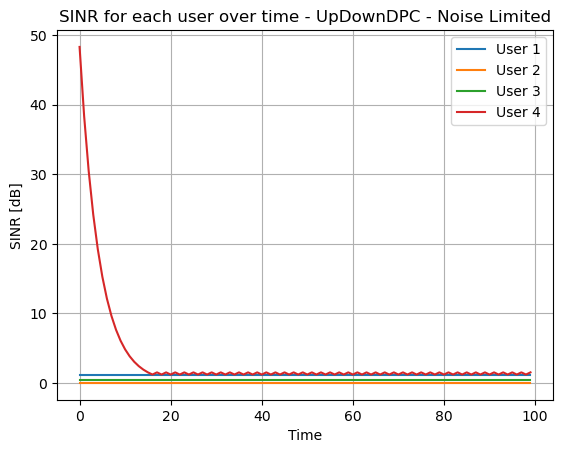

In [360]:
# Plotando a SINR para cada usuário para cada momento utilizando o UpDownDPC
plt.figure()
plt.plot(sinr_dpc_vector[0, :], label='User 1')
plt.plot(sinr_dpc_vector[1, :], label='User 2')
plt.plot(sinr_dpc_vector[2, :], label='User 3')
plt.plot(sinr_dpc_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - UpDownDPC - Noise Limited')
plt.grid()
plt.show()

In [361]:
def interference_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading):
    
    x_coord = np.array([22.583, 56.679, 76.551, 26.595])
    y_coord = np.array([20.333, 32.188, 14.688, 70.239])

    # Deixando a SINR no formato [ues, time] e a capacidade no formato [ues, time]
    sinr_max_vector = np.zeros((ues, time))
    sinr_dpc_vector = np.zeros((ues, time))
    capacity_max_vector = np.zeros((ues, time))
    capacity_dpc_vector = np.zeros((ues, time))

    # Definindo os dois tipos de controle de potência a ser utilizado:
    # 1. UpDownDPC
    transmit_power_dpc = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading, x_coord, y_coord)
    # Deixando a potência no formato [ues, time]
    transmit_power_dpc = transmit_power_dpc[0].reshape(ues, time) # Esse formato foi escolhido para facilitar a visualização dos dados e achado de maneira impirica

    # 2. Power Max
    transmit_power_max = power_trans_max*np.ones((ues, time))



    for time_index in range (time):

        # Calculando a SINR para cada usuário utilizando o Power Max
        trans_power_max_lin = dbm2lin(transmit_power_max[:, time_index])

        sinr_max = calculate_sinr(banda, K_0, aps, ues, channels, trans_power_max_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o Power Max
        capacity_max = find_capacity(sinr_max, banda, channels)

        trans_power_dpc_lin = dbm2lin(transmit_power_dpc[:,time_index])

        # Calculando a SINR para cada usuário utilizando o UpDownDPC
        sinr_dpc = calculate_sinr(banda, K_0, aps, ues, channels, trans_power_dpc_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o UpDownDPC
        capacity_dpc = find_capacity(sinr_dpc, banda, channels)

        # Alocando os valores de SINR e capacidade para cada usuário para cada momento
        sinr_max_vector[:, time_index] = sinr_max
        sinr_dpc_vector[:, time_index] = sinr_dpc
        capacity_max_vector[:, time_index] = capacity_max
        capacity_dpc_vector[:, time_index] = capacity_dpc

    return sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector
        

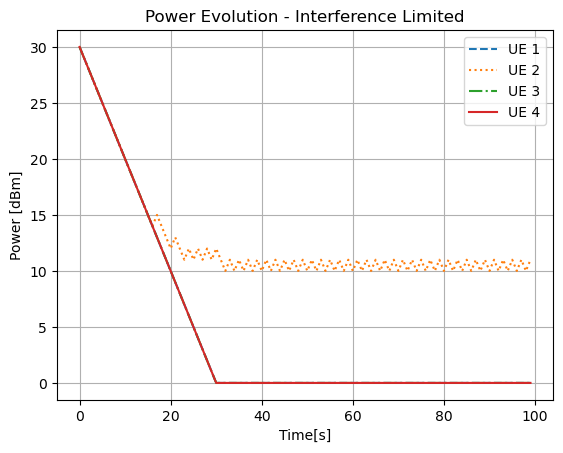

In [362]:
# Plotando a evolução da potência de transmissão

x_coord = [22.583, 56.679, 76.551, 26.595]
y_coord = [20.333, 32.188, 14.688, 70.239]

a_interference = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_interferencelimited, sigma_shadowing, sigma_fastfading, x_coord, y_coord)

a_interference = a_interference[0]

plt.figure()
plt.plot(a_interference[0], label='UE 1', linestyle='--')
plt.plot(a_interference[1], label='UE 2', linestyle=':')
plt.plot(a_interference[2], label='UE 3', linestyle='-.')
plt.plot(a_interference[3], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - Interference Limited')
plt.show()


In [363]:
sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector = interference_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_interferencelimited, sigma_shadowing, sigma_fastfading)


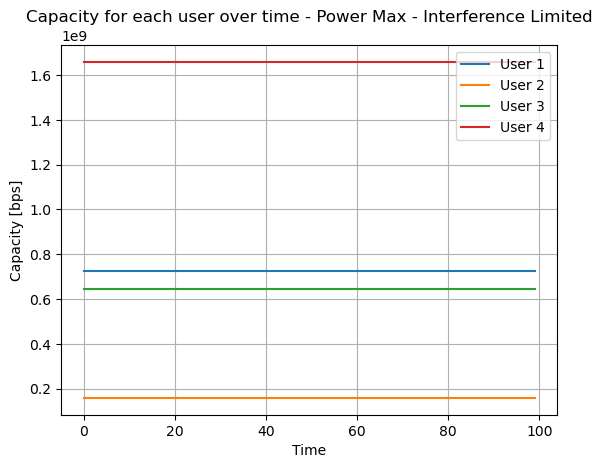

In [364]:
# Plotando a capacidade para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(capacity_max_vector[0, :], label='User 1')
plt.plot(capacity_max_vector[1, :], label='User 2')
plt.plot(capacity_max_vector[2, :], label='User 3')
plt.plot(capacity_max_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - Power Max - Interference Limited')
plt.grid()
plt.show()


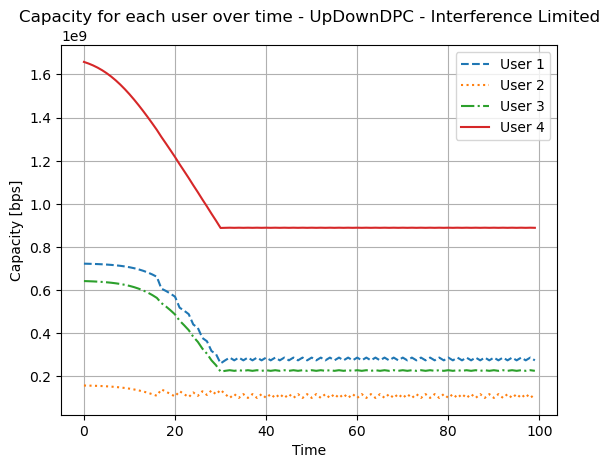

In [365]:
# Plotando a capacidade para cada usuário para cada momento utilizando o UpDownDPC
plt.figure()
plt.plot(capacity_dpc_vector[0, :], label='User 1', linestyle='--')
plt.plot(capacity_dpc_vector[1, :], label='User 2', linestyle=':')
plt.plot(capacity_dpc_vector[2, :], label='User 3', linestyle='-.')
plt.plot(capacity_dpc_vector[3, :], label='User 4', linestyle='-')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - UpDownDPC - Interference Limited')
plt.grid()
plt.show()


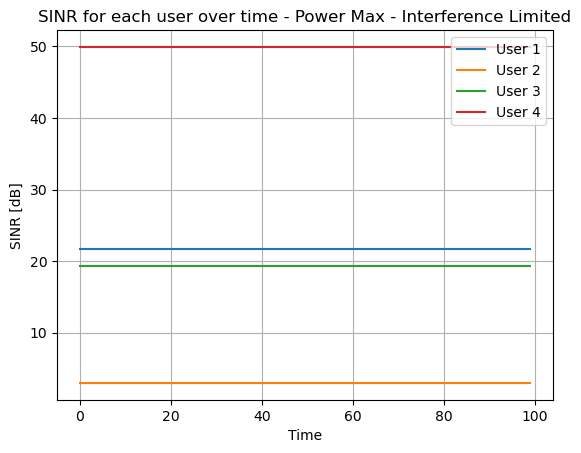

In [366]:
# Plotando a SINR para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(lin2db(sinr_max_vector[0, :]), label='User 1')
plt.plot(lin2db(sinr_max_vector[1, :]), label='User 2')
plt.plot(lin2db(sinr_max_vector[2, :]), label='User 3')
plt.plot(lin2db(sinr_max_vector[3, :]), label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - Power Max - Interference Limited')
plt.grid()
plt.show()


You are now in condition to test the two objective functions $F_1$ and $F_2$
defined above that represent two diferent views for power control in data-centric wireless
systems. Apply the ESNP algorithm above for each objective function $F_1$ and $F_2$. Adopt
$\epsilon = 0.5$ and $\delta = 10$ dBm: The number of iterations can be large for convergence. As a
suggestion, monitor the evolution of the changes in $F^*$ and $\textbf{\underline{P}}^*$
in step 12 of the ESNP
algorithm so as to identify stabilization of the convergence process. Obtain the KPIs and
organize results in graphics and tables. Compare with results from no power control and
UD-DPC of the previous exercise in both noise-limited and interference-limited scenarios
deÖned in Appendix A. Discuss with your advisor if the results make sense in light of
the two objective functions.

In [367]:
neighb_factor = 10 # epsilon
prob_param = 0.5 # Em dBm | delta

In [368]:
def espnmaxmin (aps, ues, channels, power_trans_max, power_trans_min, step, time, banda, K_0, area, x_coord, y_coord, neighb_factor, prob_param):
    # Inicializa posições dos APs e distâncias
    aps_position = distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))

    # Definindo o shadowing e o fast fading como matrizes fixas
    shadowing = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
                          [3.2318, 1.5770, 2.6449e-1, 5.6379],
                          [6.1470e-3, 1.1424, 2.6826e-1, 4.5709],
                          [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    fastfading = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                           [0.498887, 0.104890, 0.647280, 0.940906], 
                           [0.382966, 0.682700, 1.891256, 0.327100], 
                           [0.065737, 0.649500, 1.981107, 1.259538]]).reshape(channels, ues, aps)


    
    # Salvar a evolução da potência para cada UE
    power_evolution = np.zeros((ues, time))

    # Calculando a distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    # Calculando o path gain
    path_gain = find_pathgain(dist, shadowing, fastfading)

    # Setando os valores possiveis de potência de transmissão
    avaiable_power = np.arange(power_trans_min, power_trans_max + step, step)

    # Inicializa vetores de potência e alocação
    transmit_power = power_trans_max * np.ones((path_gain.shape[1], 1))

    # Valor inicial de maxmin
    f_maxmin = 0

    for time_index in range(time):
        sinr_ue = calculate_sinr(banda, K_0, aps, ues, channels, dbm2lin(transmit_power), area, x_coord, y_coord)
        sinr_ue = sinr_ue.reshape((ues, 1))
        power_evolution[:, time_index] = transmit_power.flatten()

        
        if np.min(sinr_ue) > f_maxmin:

            # Atualiza o valor de maxmin
            f_maxmin = np.min(sinr_ue)
            random = np.random.rand() # Gera um número aleatório entre 0 e 1

            # Fazendo agora o controle de potência
            if random < prob_param:
                for iteration in range(ues):
                    
                    # Atualiza a potência de transmissão pegando um valor aleatório entre os valores possíveis
                    transmit_power[iteration] = np.random.choice(avaiable_power)
            
            else: 
                transmit_power = transmit_power + neighb_factor*(np.ones((ues, 1))*np.random.rand() - 0.5) 

            # Aplica os limites de potência
            transmit_power = np.clip(transmit_power, power_trans_min, power_trans_max)

    return power_evolution


In [369]:
def espn_sumax (aps, ues, channels, power_trans_max, power_trans_min, step, time, banda, K_0, area, x_coord, y_coord, neighb_factor, prob_param):
    # Inicializa posições dos APs e distâncias
    aps_position = distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))

    # Definindo o shadowing e o fast fading como matrizes fixas
    shadowing = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
                          [3.2318, 1.5770, 2.6449e-1, 5.6379],
                          [6.1470e-3, 1.1424, 2.6826e-1, 4.5709],
                          [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    fastfading = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                           [0.498887, 0.104890, 0.647280, 0.940906], 
                           [0.382966, 0.682700, 1.891256, 0.327100], 
                           [0.065737, 0.649500, 1.981107, 1.259538]]).reshape(channels, ues, aps)


    
    # Salvar a evolução da potência para cada UE
    power_evolution = np.zeros((ues, time))

    # Calculando a distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    # Calculando o path gain
    path_gain = find_pathgain(dist, shadowing, fastfading)

    # Setando os valores possiveis de potência de transmissão
    avaiable_power = np.arange(power_trans_min, power_trans_max + step, step)

    # Inicializa vetores de potência e alocação
    transmit_power = power_trans_max * np.ones((path_gain.shape[1], 1))

    # Valor inicial de maxmin
    f_maxmin = 0

    for time_index in range(time):
        sinr_ue = calculate_sinr(banda, K_0, aps, ues, channels, dbm2lin(transmit_power), area, x_coord, y_coord)
        sinr_ue = sinr_ue.reshape((ues, 1))
        capacity_sum = np.sum(find_capacity(sinr_ue, banda, channels))

        # Salvar a evolução da potência para cada UE
        power_evolution[:, time_index] = transmit_power.flatten()

        
        if capacity_sum > f_maxmin:

            # Atualiza o valor de maxmin
            f_maxmin = capacity_sum
            random = np.random.rand() # Gera um número aleatório entre 0 e 1

            # Fazendo agora o controle de potência
            if random < prob_param:
                for iteration in range(transmit_power.shape[0]):
                    
                    # Atualiza a potência de transmissão pegando um valor aleatório entre os valores possíveis
                    transmit_power[iteration] = np.random.choice(avaiable_power)
            
            else: 
                transmit_power = transmit_power + neighb_factor*(np.ones((ues, 1))*random - 0.5) 

            # Aplica os limites de potência
            transmit_power = np.clip(transmit_power, power_trans_min, power_trans_max)

    return power_evolution


In [370]:
np.random.seed(12)

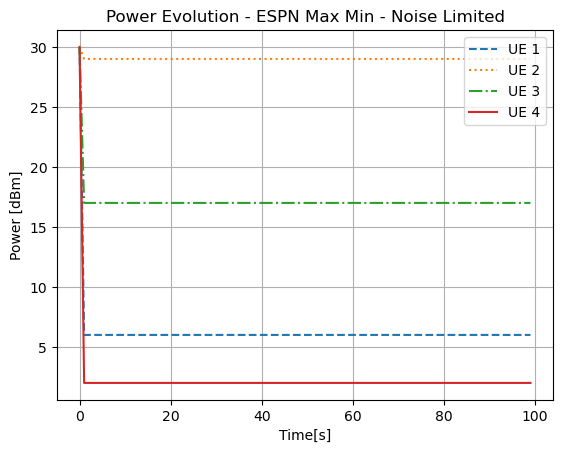

In [371]:
# Plotando a evolução da potência de transmissão para o algoritmo ESPN Max Min

x_coord = [225.83, 566.79, 765.51, 265.95]
y_coord = [203.33, 321.88, 146.88, 702.39]



espnmaxmin_power = espnmaxmin(aps, ues, channels, power_trans_max, power_trans_min, step, time, bandwidth, K_0, area_noiselimited, x_coord, y_coord, prob_param, neighb_factor)

plt.figure()
plt.plot(espnmaxmin_power[0], label='UE 1', linestyle='--')
plt.plot(espnmaxmin_power[1], label='UE 2', linestyle=':')
plt.plot(espnmaxmin_power[2], label='UE 3', linestyle='-.')
plt.plot(espnmaxmin_power[3], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - ESPN Max Min - Noise Limited')
plt.savefig('Q8_power_evolution_noiselimited_espnmaxmin.pdf')
plt.show()


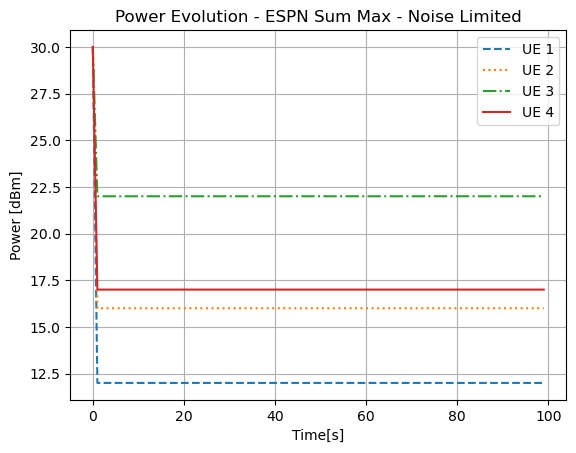

In [372]:
# Plotando a evolução da potência de transmissão para o algoritmo ESPN Sum Max

x_coord = [225.83, 566.79, 765.51, 265.95]
y_coord = [203.33, 321.88, 146.88, 702.39]

espnsumax_power = espn_sumax(aps, ues, channels, power_trans_max, power_trans_min, step, time, bandwidth, K_0, area_noiselimited, x_coord, y_coord, prob_param, neighb_factor)

plt.figure()
plt.plot(espnsumax_power[0], label='UE 1', linestyle='--')
plt.plot(espnsumax_power[1], label='UE 2', linestyle=':')
plt.plot(espnsumax_power[2], label='UE 3', linestyle='-.')
plt.plot(espnsumax_power[3], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - ESPN Sum Max - Noise Limited')
plt.savefig('Q8_power_evolution_noiselimited_espnsumax.pdf')
plt.show()



In [373]:
def espn_noise (aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area):

    # Coordenadas dos usuários pré definidas
    x_coord = np.array([225.83, 566.79, 765.51, 265.95])
    y_coord = np.array([203.33, 321.88, 146.88, 702.39])
    
    # Deixando a SINR no formato [ues, time] e a capacidade no formato [ues, time]
    sinr_espnmaxmin_vector = np.zeros((ues, time))
    sinr_espnsumax_vector = np.zeros((ues, time))
    capacity_espnmaxmin_vector = np.zeros((ues, time))
    capacity_espnsumax_vector = np.zeros((ues, time))

    # Definindo os dois tipos de controle de potência a ser utilizado:

    # 1. ESPN Max Min
    power_espnmaxmin = espnmaxmin(aps, ues, channels, power_trans_max, power_trans_min, step, time, banda, K_0, area, x_coord, y_coord, neighb_factor, prob_param)

    # 2. ESPN Sum Max
    power_espnsumax = espn_sumax(aps, ues, channels, power_trans_max, power_trans_min, step, time, banda, K_0, area, x_coord, y_coord, neighb_factor, prob_param)

    for time_index in range (time):
            
            # Calculando a SINR para cada usuário utilizando o ESPN Max Min
            sinr_espnmaxmin = calculate_sinr(banda, K_0, aps, ues, channels, dbm2lin(power_espnmaxmin[:, time_index]), area, x_coord, y_coord)

            # Calculando a capacidade para cada usuário utilizando o ESPN Max Min
            capacity_espnmaxmin = find_capacity(sinr_espnmaxmin, banda, channels)

            # Calculando a SINR para cada usuário utilizando o ESPN Sum Max

            sinr_espnsumax = calculate_sinr(banda, K_0, aps, ues, channels, dbm2lin(power_espnsumax[:, time_index]), area, x_coord, y_coord)

            # Calculando a capacidade para cada usuário utilizando o ESPN Sum Max
            capacity_espnsumax = find_capacity(sinr_espnsumax, banda, channels)

            # Alocando os valores de SINR e capacidade para cada usuário para cada momento
            sinr_espnmaxmin_vector[:, time_index] = lin2db(sinr_espnmaxmin)
            sinr_espnsumax_vector[:, time_index] = lin2db(sinr_espnsumax)
            capacity_espnmaxmin_vector[:, time_index] = capacity_espnmaxmin
            capacity_espnsumax_vector[:, time_index] = capacity_espnsumax

    return sinr_espnmaxmin_vector, sinr_espnsumax_vector, capacity_espnmaxmin_vector, capacity_espnsumax_vector


In [ ]:
# Obtendo os valores de SINR e capacidade para o algoritmo ESPN Max Min e ESPN Sum Max no cenário Noise Limited

sinr_espnmaxmin_vector, sinr_espnsumax_vector, capacity_espnmaxmin_vector, capacity_espnsumax_vector = espn_noise(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_noiselimited)

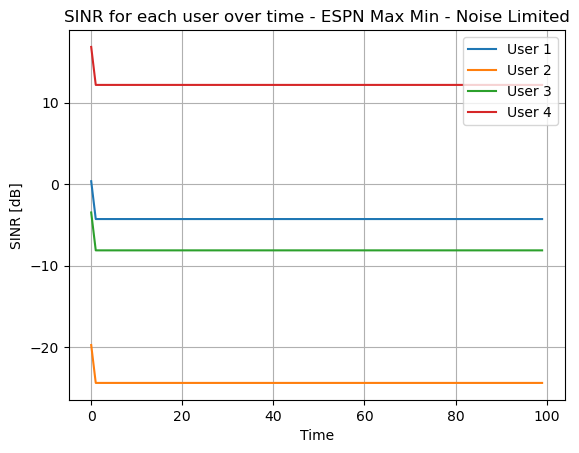

In [374]:
# Plotando a evolução da SINR para o algoritmo ESPN Max Min

plt.figure()
plt.plot(sinr_espnmaxmin_vector[0, :], label='User 1')
plt.plot(sinr_espnmaxmin_vector[1, :], label='User 2')
plt.plot(sinr_espnmaxmin_vector[2, :], label='User 3')
plt.plot(sinr_espnmaxmin_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - ESPN Max Min - Noise Limited')
plt.grid()
plt.savefig('Q8_sinr_noiselimited_espnmaxmin.pdf')
plt.show()




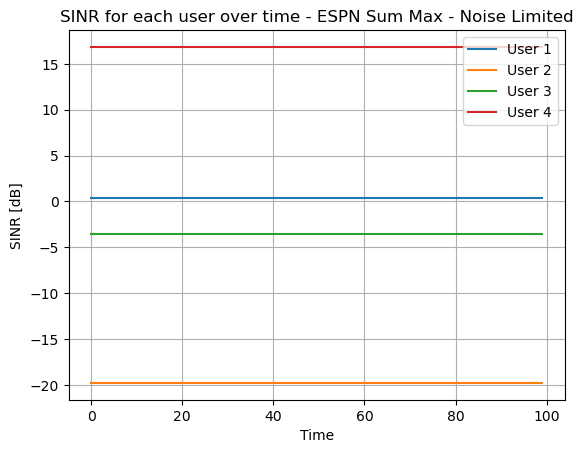

In [375]:
# Plotando a evolução da SINR para o algoritmo ESPN Sum Max

plt.figure()
plt.plot(sinr_espnsumax_vector[0, :], label='User 1')
plt.plot(sinr_espnsumax_vector[1, :], label='User 2')
plt.plot(sinr_espnsumax_vector[2, :], label='User 3')
plt.plot(sinr_espnsumax_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - ESPN Sum Max - Noise Limited')
plt.grid()
plt.savefig('Q8_sinr_noiselimited_espnsumax.pdf')
plt.show()


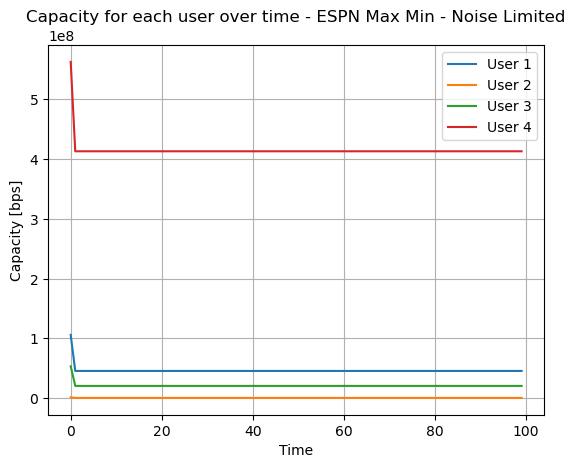

In [376]:
# Plotando a capacidade para cada usuário para cada momento utilizando o ESPN Max Min

plt.figure()
plt.plot(capacity_espnmaxmin_vector[0, :], label='User 1')
plt.plot(capacity_espnmaxmin_vector[1, :], label='User 2')
plt.plot(capacity_espnmaxmin_vector[2, :], label='User 3')
plt.plot(capacity_espnmaxmin_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - ESPN Max Min - Noise Limited')
plt.grid()
plt.savefig('Q8_capacity_noiselimited_espnmaxmin.pdf')
plt.show()


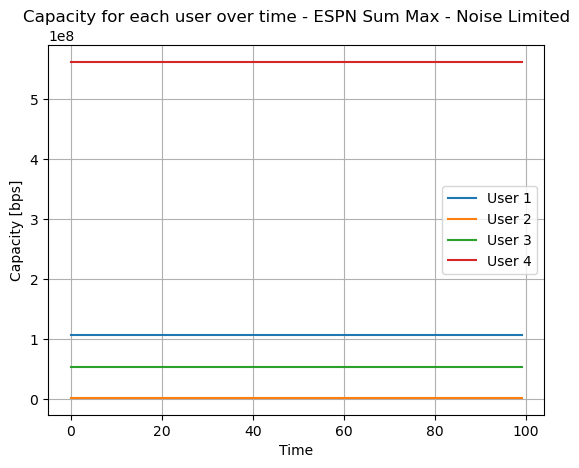

In [377]:
# Plotando a capacidade para cada usuário para cada momento utilizando o ESPN Sum Max

plt.figure()
plt.plot(capacity_espnsumax_vector[0, :], label='User 1')
plt.plot(capacity_espnsumax_vector[1, :], label='User 2')
plt.plot(capacity_espnsumax_vector[2, :], label='User 3')
plt.plot(capacity_espnsumax_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - ESPN Sum Max - Noise Limited')
plt.grid()
plt.savefig('Q8_capacity_noiselimited_espnsumax.pdf')
plt.show()


In [ ]:
def espn_interference (aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area):
    x_coord = np.array([22.583, 56.679, 76.551, 26.595])
    y_coord = np.array([20.333, 32.188, 14.688, 70.239])

    # Deixando a SINR no formato [ues, time] e a capacidade no formato [ues, time]
    sinr_espnmaxmin_vector = np.zeros((ues, time))
    sinr_espnsumax_vector = np.zeros((ues, time))
    capacity_espnmaxmin_vector = np.zeros((ues, time))
    capacity_espnsumax_vector = np.zeros((ues, time))

    # Definindo os dois tipos de controle de potência a ser utilizado:

    # 1. ESPN Max Min
    power_espnmaxmin = espnmaxmin(aps, ues, channels, power_trans_max, power_trans_min, step, time, banda, K_0, area, x_coord, y_coord, neighb_factor, prob_param)

    # 2. ESPN Sum Max
    power_espnsumax = espn_sumax(aps, ues, channels, power_trans_max, power_trans_min, step, time, banda, K_0, area, x_coord, y_coord, neighb_factor, prob_param)

    for time_index in range (time):

        # Calculando a SINR para cada usuário utilizando o ESPN Max Min
        sinr_espnmaxmin = calculate_sinr(banda, K_0, aps, ues, channels, dbm2lin(power_espnmaxmin[:, time_index]), area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o ESPN Max Min
        capacity_espnmaxmin = find_capacity(sinr_espnmaxmin, banda, channels)

        # Calculando a SINR para cada usuário utilizando o ESPN Sum Max
        sinr_espnsumax = calculate_sinr(banda, K_0, aps, ues, channels, dbm2lin(power_espnsumax[:, time_index]), area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o ESPN Sum Max
        capacity_espnsumax = find_capacity(sinr_espnsumax, banda, channels)

        # Alocando os valores de SINR e capacidade para cada usuário para cada momento
        sinr_espnmaxmin_vector[:, time_index] = lin2db(sinr_espnmaxmin)
        sinr_espnsumax_vector[:, time_index] = lin2db(sinr_espnsumax)
        capacity_espnmaxmin_vector[:, time_index] = capacity_espnmaxmin
        capacity_espnsumax_vector[:, time_index] = capacity_espnsumax

    return sinr_espnmaxmin_vector, sinr_espnsumax_vector, capacity_espnmaxmin_vector, capacity_espnsumax_vector


In [ ]:
# Obtendo os resultados para o cenário de interferência limitada

sinr_espnmaxmin_vector, sinr_espnsumax_vector, capacity_espnmaxmin_vector, capacity_espnsumax_vector = espn_interference(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_interferencelimited)


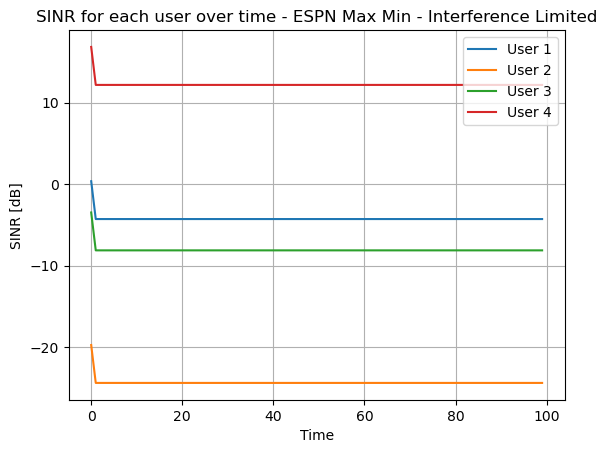

In [378]:
# Plotando a evolução da SINR para o algoritmo ESPN Max Min - Interference Limited

plt.figure()
plt.plot(sinr_espnmaxmin_vector[0, :], label='User 1')
plt.plot(sinr_espnmaxmin_vector[1, :], label='User 2')
plt.plot(sinr_espnmaxmin_vector[2, :], label='User 3')
plt.plot(sinr_espnmaxmin_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - ESPN Max Min - Interference Limited')
plt.grid()
plt.savefig('Q8_sinr_interferencelimited_espnmaxmin.pdf')
plt.show()


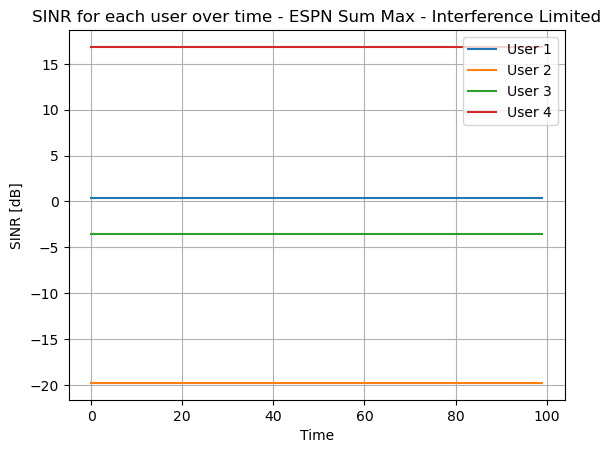

In [379]:
# Plotando a evolução da SINR para o algoritmo ESPN Sum Max - Interference Limited

plt.figure()
plt.plot(sinr_espnsumax_vector[0, :], label='User 1')
plt.plot(sinr_espnsumax_vector[1, :], label='User 2')
plt.plot(sinr_espnsumax_vector[2, :], label='User 3')
plt.plot(sinr_espnsumax_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - ESPN Sum Max - Interference Limited')
plt.grid()
plt.savefig('Q8_sinr_interferencelimited_espnsumax.pdf')
plt.show()


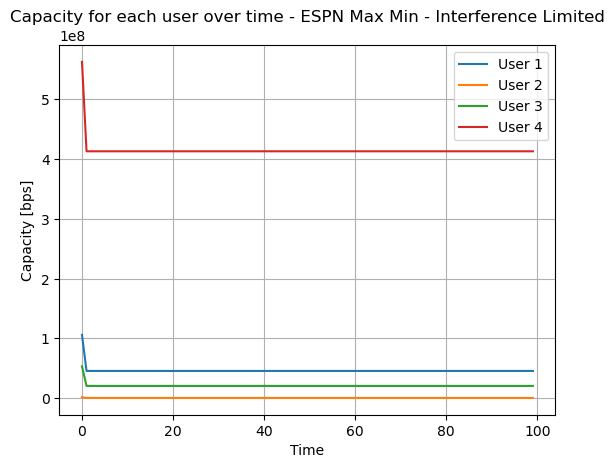

In [380]:
# Plotando a capacidade para cada usuário para cada momento utilizando o ESPN Max Min - Interference Limited

plt.figure()
plt.plot(capacity_espnmaxmin_vector[0, :], label='User 1')
plt.plot(capacity_espnmaxmin_vector[1, :], label='User 2')
plt.plot(capacity_espnmaxmin_vector[2, :], label='User 3')
plt.plot(capacity_espnmaxmin_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - ESPN Max Min - Interference Limited')
plt.grid()
plt.savefig('Q8_capacity_interferencelimited_espnmaxmin.pdf')
plt.show()



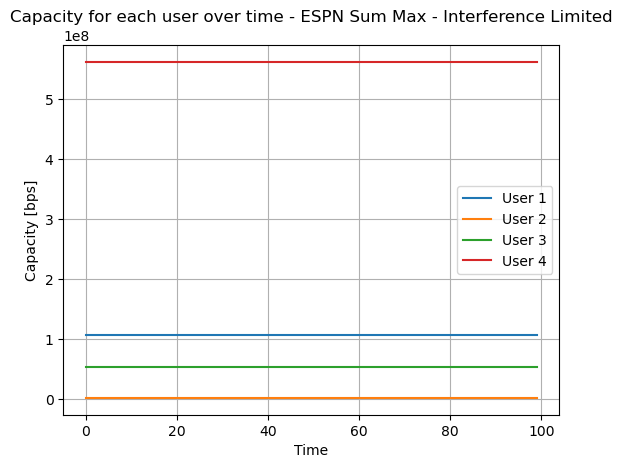

In [381]:
# Plotando a capacidade para cada usuário para cada momento utilizando o ESPN Sum Max - Interference Limited

plt.plot(capacity_espnsumax_vector[0, :], label='User 1')
plt.plot(capacity_espnsumax_vector[1, :], label='User 2')
plt.plot(capacity_espnsumax_vector[2, :], label='User 3')
plt.plot(capacity_espnsumax_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - ESPN Sum Max - Interference Limited')
plt.grid()
plt.savefig('Q8_capacity_interferencelimited_espnsumax.pdf')
plt.show()
